In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC



In [2]:
data = pd.read_csv('endsem_data.csv')


In [3]:
#Understanding the Data
print(data.info())  # for knowing column types, non-null counts
print(data.dtypes) # for any conversions
print(data.describe())  # summary of numerical features


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Converting TotalCharges to numeric as it is object and forcing errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
# Checking for missing values in TotalCharges
print(data['TotalCharges'].isnull().sum())
# Deleting the rows with missing TotalCharges
data = data.dropna(subset=['TotalCharges'])
# Verify that no missing values are present
print(data['TotalCharges'].isnull().sum())

#checking for missing values accross
missing_values = data.isnull().sum()  # Calculate missing values per column

if missing_values.any():
    missing_values = missing_values[missing_values > 0]
    plt.figure(figsize=(8, 5))
    missing_values.sort_values().plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Missing Values per Feature')
    plt.ylabel('Count')
    plt.xlabel('Feature')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("No missing values in the dataset.")

11
0
No missing values in the dataset.


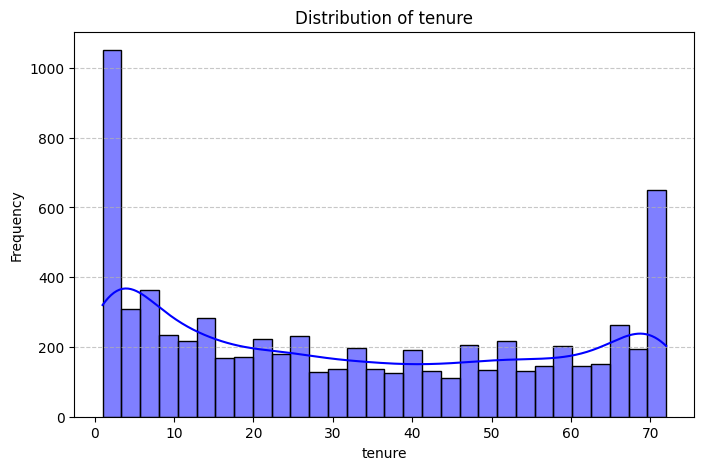

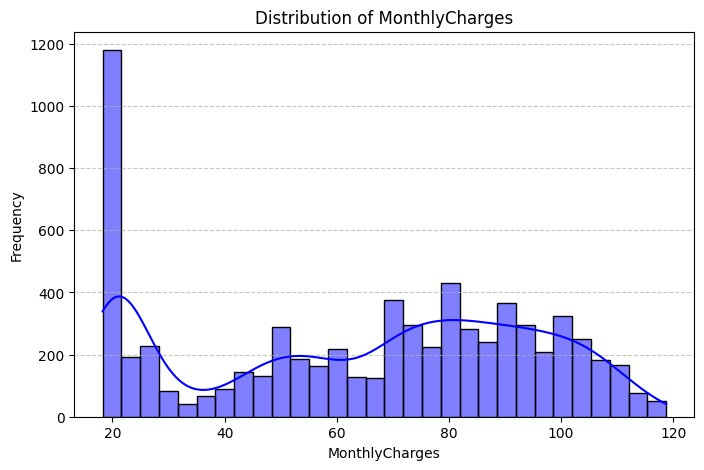

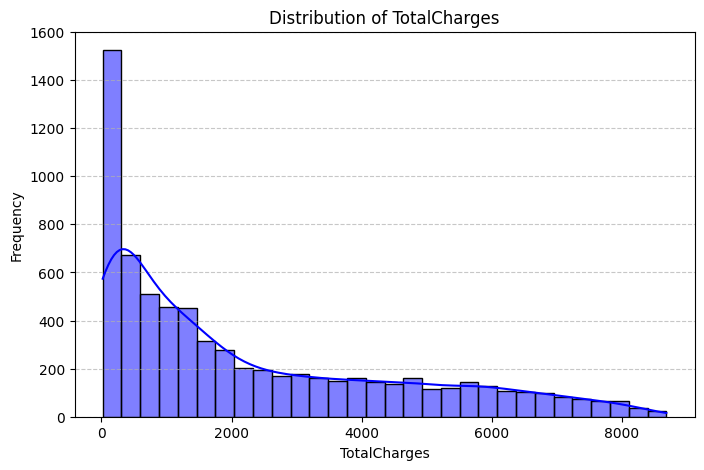

In [5]:
#Distribution of the Numerical Features 1.tenure 2.MonthlyCharges and 3. TotalCharges
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], kde=True, color='blue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [6]:
print(data.columns)

##Encoding categorical variables
#identify categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
#droping 'customerID' as it doesn't contribute to prediction
data = data.drop(columns=['customerID'],errors='ignore')
#recheck categorical_cols to ensure all columns are valid
categorical_cols = [col for col in categorical_cols if col in data.columns]
#one-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

print(data.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtectio

In [7]:
##Adding two new features 1. ChargeRatio 2. TotalServices
##Ratio of monthly charges to total charges
data['ChargeRatio'] = data['MonthlyCharges'] / (data['TotalCharges'] + 1)

# List the "Yes" columns for each service
service_cols = ['OnlineBackup_Yes', 'DeviceProtection_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']
# Sum across these columns (axis=1 to sum row-wise)
data['TotalServices'] = data[service_cols].sum(axis=1)

# Verifing the result using just head
print(data[['TotalServices']].head())
print(data[['OnlineBackup_Yes', 'DeviceProtection_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']].head())




   TotalServices
0              1
1              1
2              1
3              1
4              0
   OnlineBackup_Yes  DeviceProtection_Yes  StreamingTV_Yes  \
0              True                 False            False   
1             False                  True            False   
2              True                 False            False   
3             False                  True            False   
4             False                 False            False   

   StreamingMovies_Yes  
0                False  
1                False  
2                False  
3                False  
4                False  


In [8]:
# List of one-hot encoded columns (excluding 'Churn_Yes' as the target)
one_hot_columns = [
    'SeniorCitizen', 'tenure','gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
]

# Initialize a dictionary to store churn rates for each category
churn_rates = {}

# Calculate churn rate for each one-hot encoded column
for column in one_hot_columns:
    # Filter rows where the category is 1 (indicating the presence of that category)
    category_df = data[data[column] == 1]

    # Calculate the mean churn rate (mean of 'Churn_Yes' column, 1 means churned)
    churn_rate = category_df['Churn_Yes'].mean()

    # Store churn rate as percentage
    churn_rates[column] = round(churn_rate * 100,2)

# Sort the churn rates in descending order and print
sorted_churn_rates = dict(sorted(churn_rates.items(), key=lambda item: item[1], reverse=True))

# Print the sorted churn rates
for column, churn_rate in sorted_churn_rates.items():
    print(f'{column}: {churn_rate}%')

tenure: 61.99%
PaymentMethod_Electronic check: 45.29%
Contract_Month-to-month: 42.71%
InternetService_Fiber optic: 41.89%
OnlineSecurity_No: 41.78%
SeniorCitizen: 41.68%
TechSupport_No: 41.65%
OnlineBackup_No: 39.94%
DeviceProtection_No: 39.14%
StreamingMovies_No: 33.73%
PaperlessBilling_Yes: 33.59%
StreamingTV_No: 33.54%
Partner_No: 32.98%
Dependents_No: 31.28%
StreamingTV_Yes: 30.11%
StreamingMovies_Yes: 29.95%
MultipleLines_Yes: 28.65%
gender_Female: 26.96%
PhoneService_Yes: 26.75%
gender_Male: 26.2%
MultipleLines_No: 25.08%
PhoneService_No: 25.0%
MultipleLines_No phone service: 25.0%
DeviceProtection_Yes: 22.54%
OnlineBackup_Yes: 21.57%
Partner_Yes: 19.72%
PaymentMethod_Mailed check: 19.2%
InternetService_DSL: 19.0%
PaymentMethod_Bank transfer (automatic): 16.73%
PaperlessBilling_No: 16.38%
Dependents_Yes: 15.53%
PaymentMethod_Credit card (automatic): 15.25%
TechSupport_Yes: 15.2%
OnlineSecurity_Yes: 14.64%
Contract_One year: 11.28%
StreamingTV_No internet service: 7.43%


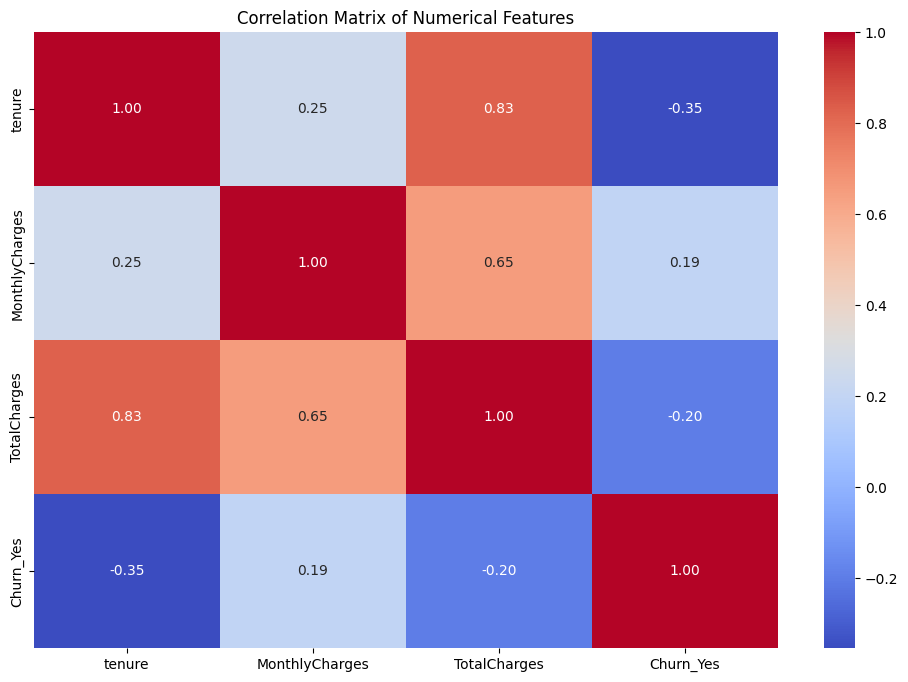

In [9]:
#Correlation Heatmap of numerical features with target: Churn_Yes
plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_cols + ['Churn_Yes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [10]:
##Split Dataset

X = data.drop(columns=['Churn_Yes', 'Churn_No'])  # Drop target and unnecessary columns
y = data['Churn_Yes']                            # Binary target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print data dimensions for verification
print(f"Training Features: {X_train.shape}, Testing Features: {X_test.shape}")
print(f"Training Labels: {y_train.shape}, Testing Labels: {y_test.shape}")

Training Features: (5625, 47), Testing Features: (1407, 47)
Training Labels: (5625,), Testing Labels: (1407,)



Starting Grid Search...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Grid Search Complete!

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.7950

Feature Importance from the Tuned Decision Tree:
                           Feature  Importance
36         Contract_Month-to-month    0.524754
16     InternetService_Fiber optic    0.116782
45                     ChargeRatio    0.110156
1                           tenure    0.060546
2                   MonthlyCharges    0.059429
3                     TotalCharges    0.026553
27                  TechSupport_No    0.020629
37               Contract_One year    0.019256
43  PaymentMethod_Electronic check    0.018726
11                PhoneService_Yes    0.011438

Selected Features (Importance > 0.01): ['Contract_Month-to-month', 'InternetService_Fiber optic', 'ChargeRatio', 'tenure', 'MonthlyCharges', 'TotalCharges', 'TechSupport_No'

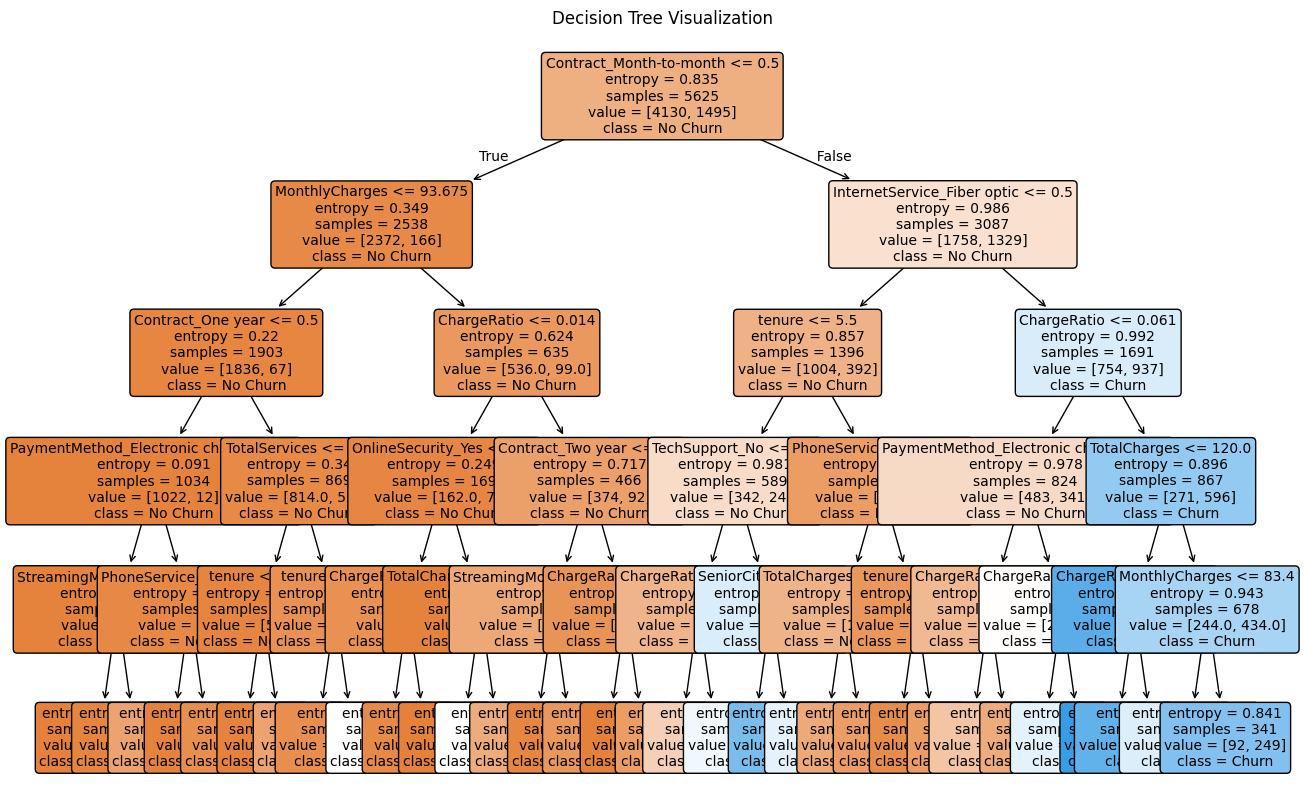

In [11]:
##Decision Tree Classifier with Hyperparameter Tuning for final feature selection

#Parameter Grid for Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],               # Focus on reasonable tree depths
    'min_samples_split': [2, 5, 10, 20],      # Ensure splits happen only with sufficient data
    'min_samples_leaf': [1, 2, 5],            # Minimum size of leaf nodes
    'criterion': ['gini', 'entropy'],         # Evaluate Gini and Entropy for splits
}

# Initialize the DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    cv=5,                  #5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
print("\nStarting Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search Complete!")

# Extract the best model and its parameters
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

print("\nBest Hyperparameters:", best_params)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

##Evaluate the Best Model

# # Predict using the best model
# y_pred = best_tree.predict(X_test)

# # Evaluate performance
# accuracy_dt = accuracy_score(y_test, y_pred)
# precision_dt = precision_score(y_test, y_pred)
# recall_dt = recall_score(y_test, y_pred)
# f1_dt = f1_score(y_test, y_pred)

# # Print evaluation results
# print("\nEvaluation Metrics on Test Data:")
# print(f"Accuracy: {accuracy_dt:.4f}")
# print(f"Precision: {precision_dt:.4f}")
# print(f"Recall: {recall_dt:.4f}")
# print(f"F1 Score: {f1_dt:.4f}")


#Feature Importance

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance from the Tuned Decision Tree:")
print(feature_importances.head(10))  #choosing top 10 features

# Select top features based on importance
selected_features = feature_importances[feature_importances['Importance'] > 0.01]['Feature'].tolist()

print("\nSelected Features (Importance > 0.01):", selected_features)


#Reduce Dataset to Selected Features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

print(f"\nReduced Training Features: {X_train_reduced.shape}")
print(f"Reduced Testing Features: {X_test_reduced.shape}")


#Visualize the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(
    best_tree,
    filled=True,
    feature_names=X_train.columns.tolist(),  #Use features from the full dataset
    class_names=['No Churn', 'Churn'],       #target classes
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


In [12]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

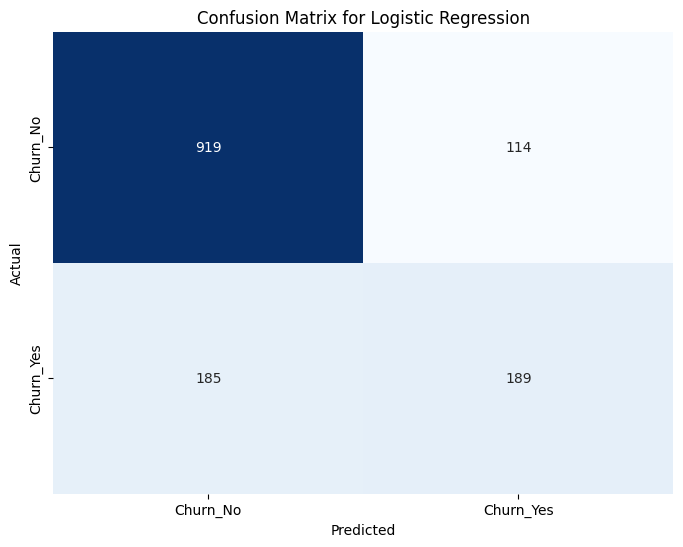

Confusion Matrix:
[[919 114]
 [185 189]]
Evaluation metrics:
Accuracy: 0.7875
Precision: 0.6238
Recall: 0.5053
F1 Score: 0.5583


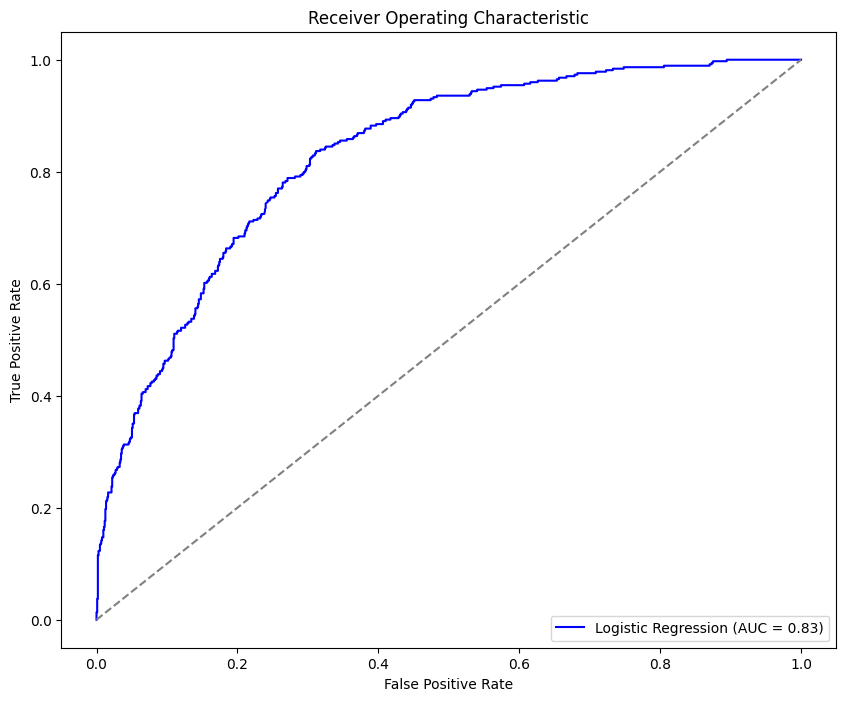

In [13]:
##LOGISTICAL REGRESSION WITHOUT HYPERPARAMETER TUNING
## LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Create the Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000, solver='saga')

# Fit the model
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test_scaled)

## Confusion Matrix
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn_No', 'Churn_Yes'], yticklabels=['Churn_No', 'Churn_Yes'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Confusion Matrix:")
print(cm)

# Calculate Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)

print("Evaluation metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


#the ROC curve using the model
fpr, tpr, _ = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:, 1])  # For logistic regression
roc_auc = auc(fpr, tpr)

#Ploting multiple models
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-validation Accuracy: 0.8073


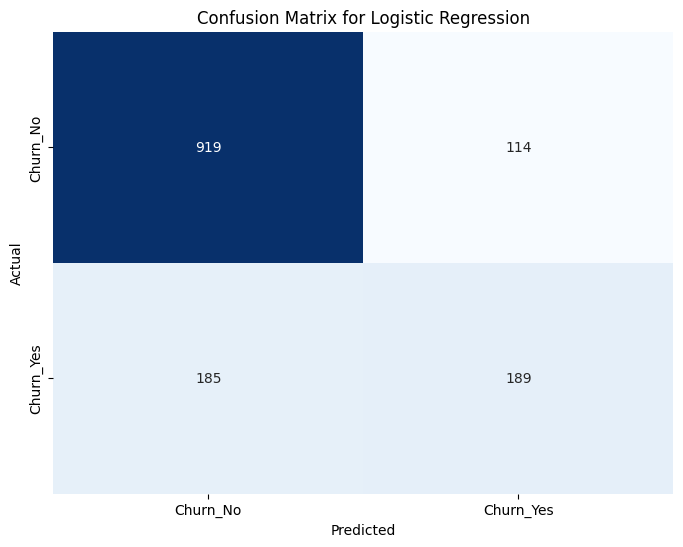

Confusion Matrix:
[[919 114]
 [185 189]]
Evaluation metrics:
Accuracy: 0.7875
Precision: 0.6238
Recall: 0.5053
F1 Score: 0.5583


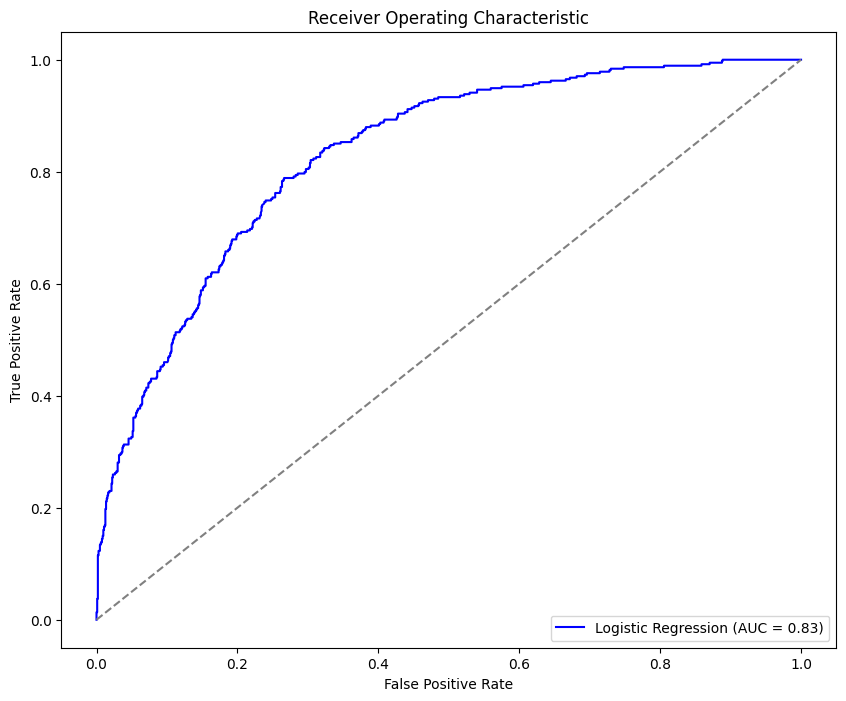

In [14]:
##LOGISTICAL REGRESSION WITH HYPERPARAMETER TUNING
#Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],               # Regularization strength
    'penalty': ['l2', 'l1'],                             # Regularization type
    'solver': ['liblinear', 'saga'],                     # Solvers for optimization
    'max_iter': [1000]                         # Maximum number of iterations
}

#Create the Logistic Regression model
logreg = LogisticRegression(random_state=42)

#Perform GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

#Fit the model
grid_search.fit(X_train_scaled, y_train)

#Print the best parameters and score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")

#Get the best model from grid search
best_logreg = grid_search.best_estimator_

#Evaluate the tuned model on the test set
y_pred_logreg = best_logreg.predict(X_test_scaled)

## Confusion Matrix
#Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

#Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn_No', 'Churn_Yes'], yticklabels=['Churn_No', 'Churn_Yes'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print("Confusion Matrix:")
print(cm)

#Calculate Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)

print("Evaluation metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#the ROC curve using the model
fpr, tpr, _ = roc_curve(y_test, best_logreg.predict_proba(X_test_scaled)[:, 1])  # For logistic regression
roc_auc = auc(fpr, tpr)

#Ploting multiple models
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [15]:
##to save the best model
import pickle

# Save the best model, scaler, and encoders
with open("logreg_model_tuned.pkl", "wb") as file:
    pickle.dump((best_logreg, scaler), file)

print("Model saved as 'logreg_model_tuned.pkl'")

Model saved as 'logreg_model_tuned.pkl'


Random Forest - Accuracy: 0.7619
Random Forest - Precision: 0.5661
Random Forest - Recall: 0.4465
Random Forest - F1 Score: 0.4993


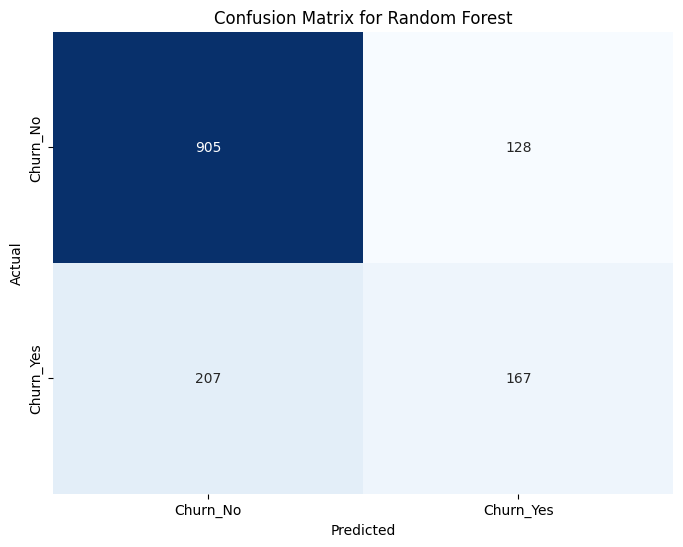

Confusion Matrix for Random Forest:
[[905 128]
 [207 167]]


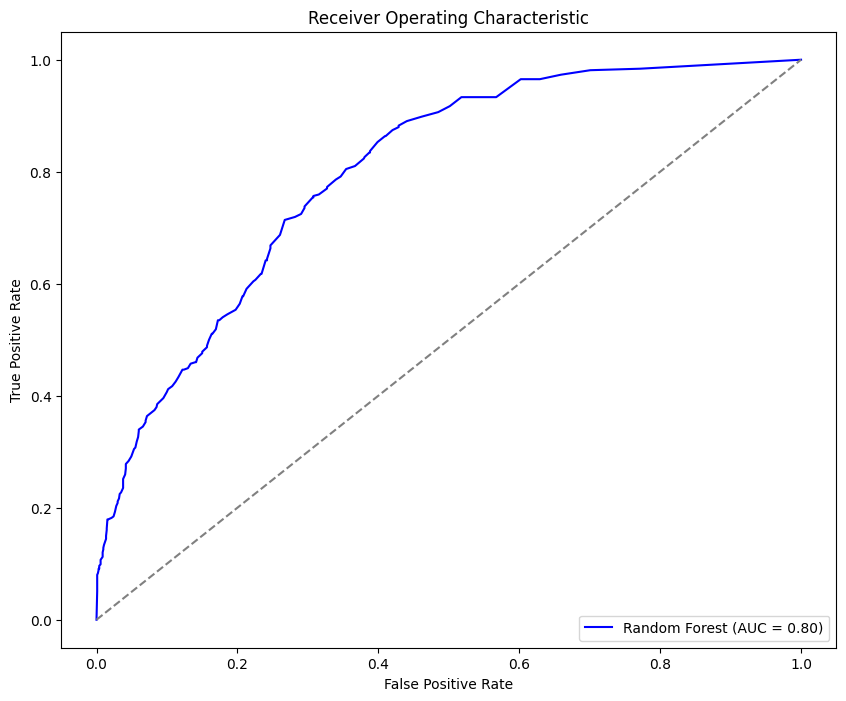

In [16]:
#RANDOM FOREST WITHOUT HYPERPARAMETER TUNING

#Initialize
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)

#Train the model
rf.fit(X_train_scaled, y_train)

#Make predictions on the test set
y_pred_rf = rf.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}")
print(f"Random Forest - Recall: {recall_rf:.4f}")
print(f"Random Forest - F1 Score: {f1_rf:.4f}")

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn_No', 'Churn_Yes'], yticklabels=['Churn_No', 'Churn_Yes'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Print the confusion matrix
print("Confusion Matrix for Random Forest:")
print(cm_rf)

#the ROC curve using the model
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test_scaled)[:, 1])  # For Random Forest
roc_auc = auc(fpr, tpr)

# Plot ROC curve for multiple models
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Neural Network - Accuracy: 0.7868
Neural Network - Precision: 0.6321
Neural Network - Recall: 0.4733
Neural Network - F1 Score: 0.5413


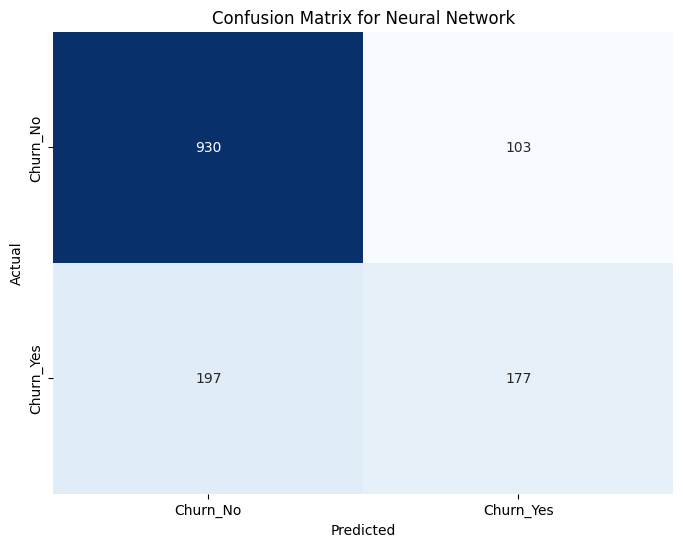

Confusion Matrix for Neural Network:
[[930 103]
 [197 177]]


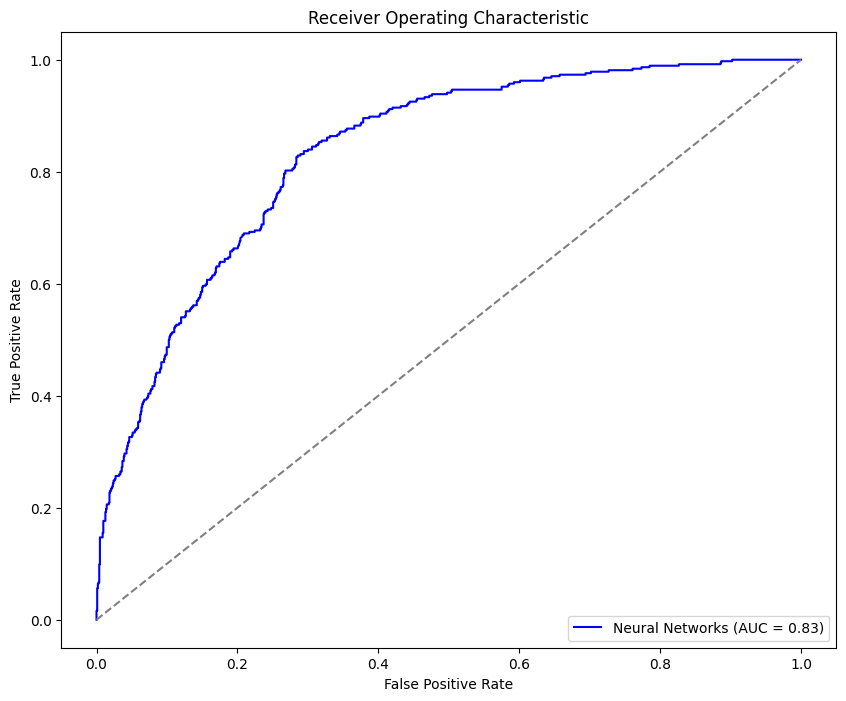

In [17]:
#NEURAL NETWORK WITHOUT HYPERPARAMETER TUNING
## NEURAL NETWORK

# 1. Define the Neural Network (MLP) model
mlp = MLPClassifier(
    random_state=42,
    max_iter=2500,
    hidden_layer_sizes=(100,),  # Default hidden layer size
    activation='tanh',          # Default activation function
    solver='adam',              # Default solver
    learning_rate='constant'    # Default learning rate schedule
)

# 2. Fit the model to the training data
mlp.fit(X_train_scaled, y_train)

# 3. Evaluate the model on the test set
y_pred_nn = mlp.predict(X_test_scaled)

# 4. Metrics and evaluation
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print(f"Neural Network - Accuracy: {accuracy_nn:.4f}")
print(f"Neural Network - Precision: {precision_nn:.4f}")
print(f"Neural Network - Recall: {recall_nn:.4f}")
print(f"Neural Network - F1 Score: {f1_nn:.4f}")

# 5. Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)

# 6. Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn_No', 'Churn_Yes'], yticklabels=['Churn_No', 'Churn_Yes'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7. Print the confusion matrix
print("Confusion Matrix for Neural Network:")
print(cm_nn)

#the ROC curve using the model
fpr, tpr, _ = roc_curve(y_test, mlp.predict_proba(X_test_scaled)[:, 1])  # For Neural networks
roc_auc = auc(fpr, tpr)

# Plot ROC curve for multiple models
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'Neural Networks (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


SVM - Accuracy: 0.7832
SVM - Precision: 0.6082
SVM - Recall: 0.5187
SVM - F1 Score: 0.5599


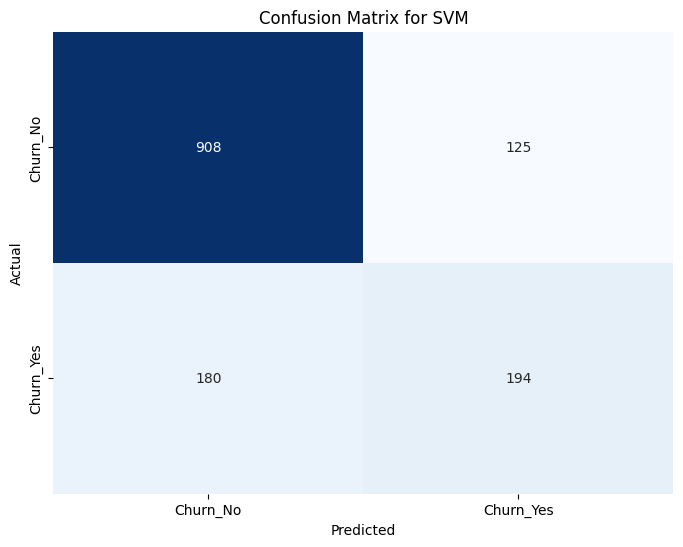

Confusion Matrix for SVM:
[[908 125]
 [180 194]]


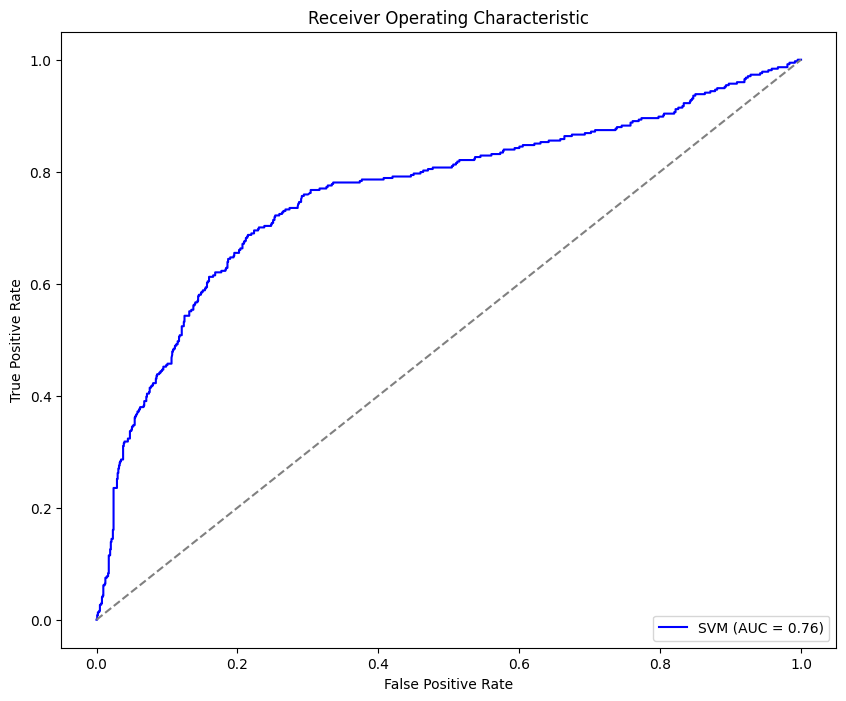

In [20]:
#SVM WITHOUT USING HYPERPARAMETER TUNING
#Define the SVM model
svm = SVC(
    random_state=42,
    kernel='rbf',  # Default kernel type
    C=1.0,         # Default regularization parameter
    gamma='scale', # Default kernel coefficient
    probability=True  # Required for ROC and probability-based metrics
)

#Train the model
svm.fit(X_train_scaled, y_train)

#Evaluate the model on the test set
y_pred_svm = svm.predict(X_test_scaled)

#Metrics and evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"SVM - Accuracy: {accuracy_svm:.4f}")
print(f"SVM - Precision: {precision_svm:.4f}")
print(f"SVM - Recall: {recall_svm:.4f}")
print(f"SVM - F1 Score: {f1_svm:.4f}")

#Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

#Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Churn_No', 'Churn_Yes'], yticklabels=['Churn_No', 'Churn_Yes'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Print the confusion matrix
print("Confusion Matrix for SVM:")
print(cm_svm)


#the ROC curve using the model
fpr, tpr, _ = roc_curve(y_test, svm.predict_proba(X_test_scaled)[:, 1])  # For SVM
roc_auc = auc(fpr, tpr)

#Plot ROC curve for multiple models
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



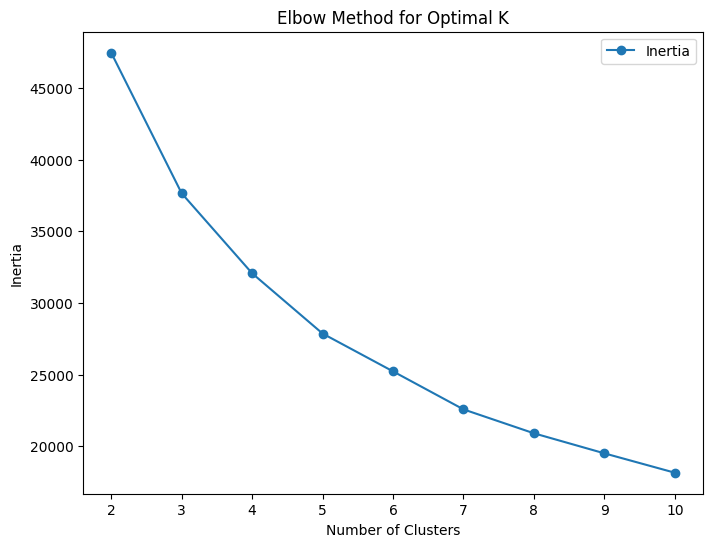

Silhouette Score for K-Means Clustering: 0.2353


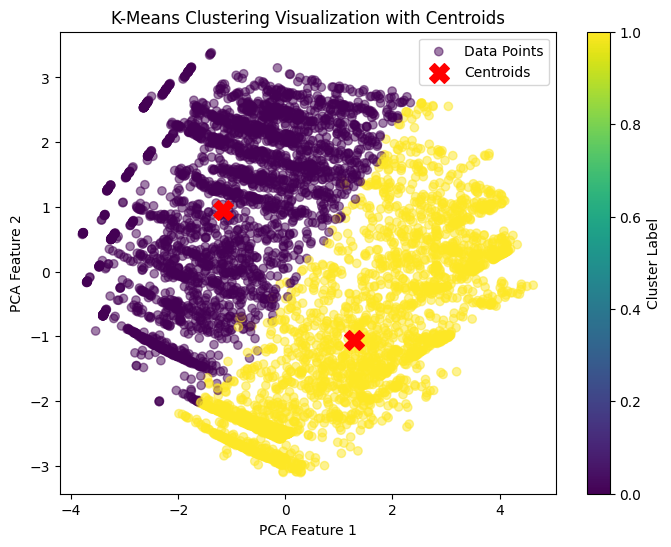

Cluster Centers (PCA-Reduced):
[[-1.16155216  0.95537461]
 [ 1.2837064  -1.05584627]]


In [21]:
#Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)  # Start from 2 since silhouette score isn't valid for k=1
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_train_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_train_scaled, clusters)
    silhouette_scores.append(score)

#Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.legend()
plt.show()


#Choose the optimal number of clusters (e.g., based on Silhouette Score or Elbow Method)
optimal_clusters = 2  # You can update this based on the plots above
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_scaled)

#Add the cluster labels as a new feature
X_train_df = pd.DataFrame(X_train_scaled, columns=[f'Feature_{i}' for i in range(X_train_scaled.shape[1])])
X_train_df['Cluster'] = clusters

#Evaluate the clustering using silhouette score
silhouette_avg = silhouette_score(X_train_scaled, clusters)
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg:.4f}")

#Visualization of the clusters using PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(X_train_scaled)
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering Visualization with Centroids')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

#Use the clusters as features for predictive modeling
# Add the cluster labels to the test set
test_clusters = kmeans.predict(X_test_scaled)
X_test_df = pd.DataFrame(X_test_scaled, columns=[f'Feature_{i}' for i in range(X_test_scaled.shape[1])])
X_test_df['Cluster'] = test_clusters

#Debugging Output
print(f"Cluster Centers (PCA-Reduced):\n{centroids}")



In [22]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"best_logreg.coef_ shape: {best_logreg.coef_.shape}")

X_train_scaled shape: (5625, 11)
best_logreg.coef_ shape: (1, 11)


                           Feature  Coefficient
0          Contract_Month-to-month     0.716081
1      InternetService_Fiber optic     0.418378
4                   MonthlyCharges     0.395360
2                      ChargeRatio     0.392544
6                   TechSupport_No     0.215424
7                Contract_One year     0.201175
8   PaymentMethod_Electronic check     0.186859
10                   TotalServices     0.130899
5                     TotalCharges     0.000000
9                 PhoneService_Yes    -0.208790
3                           tenure    -0.530123


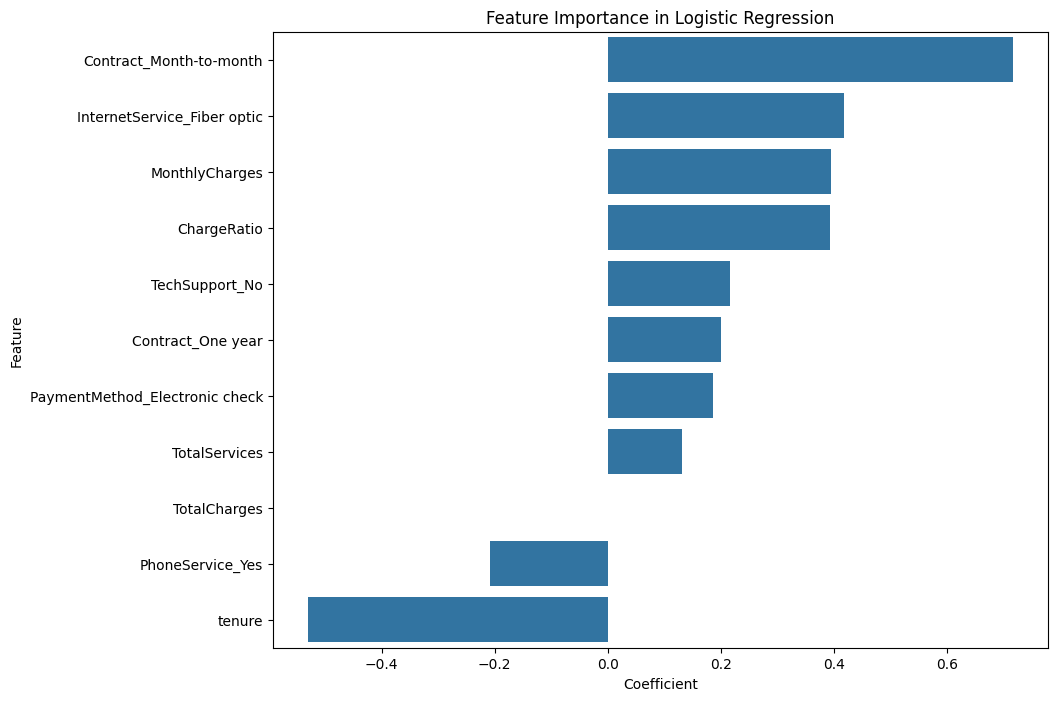

In [23]:
##Feature importance for logistic regression
feature_importance = pd.DataFrame({
    'Feature': selected_features,  # Use decision tree-selected features
    'Coefficient': best_logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression')
plt.show()



In [24]:
import pickle
import pandas as pd

# Load the saved model, scaler, and encoders
with open("logreg_model_tuned.pkl", "rb") as file:
    best_logreg, scaler = pickle.load(file)

# Load the sample data
sample_data = pd.read_csv("sample_data.csv")

# Ensure TotalCharges and MonthlyCharges are numeric
sample_data['TotalCharges'] = pd.to_numeric(sample_data['TotalCharges'], errors='coerce')
sample_data['MonthlyCharges'] = pd.to_numeric(sample_data['MonthlyCharges'], errors='coerce')

# Fill missing TotalCharges with 0 (if any)
sample_data['TotalCharges'].fillna(0, inplace=True)

# Add or recalculate custom features
sample_data['ChargeRatio'] = sample_data['MonthlyCharges'] / (sample_data['TotalCharges'] + 1)

# Define the service columns
service_cols = ['OnlineBackup_Yes', 'DeviceProtection_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']

# Ensure the service columns are present (one-hot encoded) in the sample data
sample_data_encoded = pd.get_dummies(sample_data, columns=['OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'], drop_first=False)

# Ensure required service columns exist after encoding
for col in service_cols:
    if col not in sample_data_encoded.columns:
        sample_data_encoded[col] = 0

# Sum across these columns to calculate TotalServices
sample_data_encoded['TotalServices'] = sample_data_encoded[service_cols].sum(axis=1)

# Define the selected features
selected_features = [
    'Contract_Month-to-month',
    'InternetService_Fiber optic',
    'ChargeRatio',
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'TechSupport_No',
    'Contract_One year',
    'PaymentMethod_Electronic check',
    'PhoneService_Yes',
    'TotalServices'
]

# Ensure all selected features are present (fill missing columns with 0)
for feature in selected_features:
    if feature not in sample_data_encoded.columns:
        sample_data_encoded[feature] = 0

# Extract only the selected features
X_sample = sample_data_encoded[selected_features]

# Scale the features
X_sample_scaled = scaler.transform(X_sample)

# Make predictions
sample_predictions = best_logreg.predict(X_sample_scaled)
sample_probabilities = best_logreg.predict_proba(X_sample_scaled)[:, 1]  # Probability of Churn = 1

# Add predictions and probabilities to the sample data
sample_data['Churn_Prediction'] = sample_predictions
sample_data['Churn_Probability'] = sample_probabilities

# Save the predictions to a new file
sample_data.to_csv("sample_data_predictions.csv", index=False)
print("Predictions saved to 'sample_data_predictions.csv'")


Predictions saved to 'sample_data_predictions.csv'


<ipython-input-24-69fee3eded5d>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_data['TotalCharges'].fillna(0, inplace=True)
